# Description
Additional analysis on data


# Loads modules and packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pylab as pl
from pynamika import *

import re
import os
import shutil
import glob
from skimage import data, io, filters, exposure
import nibabel as nib
import copy
import json
from scipy import signal
from scipy import stats
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_laplace
from scipy.ndimage.filters import median_filter
from scipy.ndimage.measurements import maximum_position
from scipy import ndimage

from pybxd.readBxdImage import read_bxd_image
def write2StudyIndex(Path2JsonFile, Key, Value):
    sifid = open(Path2JsonFile,'r')
    study_index = json.load(sifid)
    sifid.close()
    
    study_index[Key] = Value
    
    with open(Path2JsonFile,'w') as jFile:
        json.dump(study_index, jFile)
    print('***** File {} updated *****'.format(Path2JsonFile))


# Auxiliar Functions

## Load CVS file

In [2]:
def loadImages(PATH2IMG):
    """
    
    """        
    IMFID  = nib.load(PATH2IMG)
    IMDATA = IMFID.get_data()
    
    return IMDATA

In [3]:
def ReadXTR(Path2XTR):
    
    d = {}
    with open(Path2XTR) as f:
        for line in f:
#             d=dict([line.split() for line in f]) -- It doesn't give the argument as number (i.e. float)
            (key, val) = line.split()
            d[key] = float(val)    
            
    return d

In [4]:
def MakeStdMatrix(Dyn_data,TimeInterval):
#Create a matrix which intensity depend on the movement present in Dyn_data over time (dimension 4)

    
    Dyn_data_f= Dyn_data
    #Dyn_data_f= convolve1d(Dyn_data_f,[+1,1,0,-1,-1],1)

    MeanSlice = np.nanmean(Dyn_data_f,3)
    #penalize high intensity pixels (organs), without advantage noise too much
    MeanSlice =MeanSlice/np.max(MeanSlice)+0.08
    MeanSlice[MeanSlice>1] = 1

    #Calculate the std matrix along the time dimension, but only on time interval (ie, half acquisition)
    MatrixStdCalc = np.zeros((Data.shape[0],Data.shape[1],NumberSlice ))
    for rrows in range(Data.shape[0]) :
        for ccols in range(Data.shape[1]) :
            for sslice in range(NumberSlice):
                Signal = Dyn_data_f[rrows,ccols,sslice,TimeInterval].squeeze() 
                MatrixStdCalc[rrows,ccols,sslice] = np.std(Signal)/(MeanSlice[rrows,ccols,sslice])
    #blur slightly images, bring noise and small details down            
    MatrixStdCalc1= median_filter(MatrixStdCalc,size=(1,5,1))  
    MatrixStdCalc1[MatrixStdCalc1<0]=0
    return MatrixStdCalc1


End of Section - Auxiliar Functions

# Defines path to data and performs file conversion

In [7]:
DATAID     = ['2002']
CONFIGNAME = 'pulmolux-oe-ms2d-config'

ServerPath   = os.path.join(os.sep, 'Volumes' , 'Data')
Path2Data       = os.path.join(os.sep, ServerPath, 'GSK-13-2', 'HF', DATAID[0] , 'visit1')
Path2Analyze    = os.path.join(Path2Data, 'analyze')
Path2Tmp = os.path.join(Path2Data,'analysis', 'tmp')

In [8]:
DynPattern   = 'DYNAMIC_'
T1mapPattern = '_80_'
REF_SLICES = []
for dataset in DATAID:
    print(os.path.join(Path2Analysis , '*{}*'.format(DynPattern)))
    DynID         = glob.glob(os.path.join(Path2Analyze , '*{}*'.format(DynPattern)))
    get_snxx      = DynID[0].split('_')[1]
    print(get_snxx)
    REF_SLICES.append(get_snxx)
    print('For dataset {}, ref_slices={}'.format(dataset, get_snxx))
print('All done. Check there are no error messages before moving to the next cells')

/Volumes/Data/GSK-13-2/HF/2002/visit1/analyze/*DYNAMIC_*
Fast
For dataset 2002, ref_slices=Fast
All done. Check there are no error messages before moving to the next cells


In [9]:
#Find the name of each slice

DictFA={}
DictRep={}
FAnames=[]
counter=0
counterFA=0
counterRep=0
Rep_counterDyn = 0


for dataset in DATAID:
    ListOfFiles   = os.listdir(Path2Analysis)  
    for file in ListOfFiles: 
        if (file.find(T1mapPattern)>0) & file.endswith('.img') :
            if counterFA==0: #load one file, to understand the size
                Data= loadImages(os.path.join(Path2Analysis,file))
            FA_ind= (file.find('deg')) #this TI ind
            FAfile = file[FA_ind-3:FA_ind]
            if FAnames.count(FAfile) == 0:
                FAnames.append(FAfile)
                counterFA=counterFA+1
            Rep_ind= (file.find('tp')) #this TI ind
            Repfile = file[Rep_ind:Rep_ind+6]
            try: 
                index =int(DictRep[Repfile])
            except:
                DictRep[Repfile] = counterRep
                counterRep=counterRep+1
        if (file.find(DynPattern )>0) & file.endswith('.img') :
            Rep_ind= (file.find('C__')) #this TI ind
            Repetition = np.int(file[Rep_ind+3:Rep_ind+6])
            if Repetition>Rep_counterDyn:
                Rep_counterDyn=Repetition
print('All done. Check there are no error messages before moving to the next cells')    
NumbersFA = np.zeros((len(FAnames),1))
print(FAnames)
for FA in range(len(FAnames)):
    Num=re.findall(r'\d+',FAnames[FA])
    NumbersFA[FA] = Num[0]
FAnamesA=np.array(FAnames)

inds = np.argsort(NumbersFA,0)
NumbersFASorted =np.sort(NumbersFA,0)
FAnamesOrdered = FAnamesA[inds]
FAnamesO=list(FAnamesOrdered )
for FA in range(FAnamesOrdered.shape[0]):
    aa =(FAnamesO[FA][0])
    print(aa)
    DictFA[aa]=FA #dictionary ordered for TI values
print(DictRep)

All done. Check there are no error messages before moving to the next cells
['R_2', 'R_4', 'R_7', '_10']
R_2
R_4
R_7
_10
{'': 0}


In [10]:

DictRep={'_001':0,'_002':1,'_003':2, '_004':3, '_005':4, '_006':5, '_007':6, '_008':7, '_009':8,'_010':9  }

In [11]:
#load all file in the dynamics - Acquisition 10 - in Dyn_data and the T1 maps data in T1_data
ListOfFiles = os.listdir(Path2Analysis)
counter=-1
NAverages=len(DictRep)
NumFA= len(DictFA)

Dyn_data=np.zeros((Data.shape[0],Data.shape[1],Data.shape[2] ,Rep_counterDyn))# dim1,dim2,dim3,dyn
T1_data=np.zeros((Data.shape[0],Data.shape[1],Data.shape[2] ,NumFA,NAverages))
T1_data_reorder=np.zeros((Data.shape[0],Data.shape[1],Data.shape[2] ,NumFA*NAverages))


for file in ListOfFiles:
    if (file.find(DynPattern)>0) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Analysis,file));
        counter=counter+1
        Dyn_data[:,:,:,counter]= DataF.squeeze()
    elif (file.find(T1mapPattern)>0) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Analysis,file));
        FA_ind= (file.find('deg'))
        FAfile = file[FA_ind-3:FA_ind]
        indexFA =int(DictFA[FAfile])
        Rep_ind= (file.find('80__')) #this TI ind
        if Rep_ind<1 : 
            Rep_ind= (file.find('80_'))
            Repfile = file[Rep_ind+2:Rep_ind+6]
        else:
            Repfile = file[Rep_ind+3:Rep_ind+7]
        indexRep = int(DictRep[Repfile])
        T1_data[:,:,:,indexFA,indexRep ]= DataF.squeeze()
        T1_data_reorder[:,:,:,indexFA*NAverages+indexRep ]= DataF.squeeze()# dim1,dim2,dim3,TI*rep

Find the diaphragm position

In [12]:
NumberSlice= Dyn_data.shape[2]
#Calculate the std matrix along the time dimension, without the first part presenting the first pass
TimeInterval = (np.arange(Dyn_data.shape[3]-50,np.int(np.ceil(Dyn_data.shape[3])),1))
TimeInterval = np.arange(0,40,1)
MatrixStd =  MakeStdMatrix(Dyn_data,TimeInterval)
# Put margins to zero, just to be sure





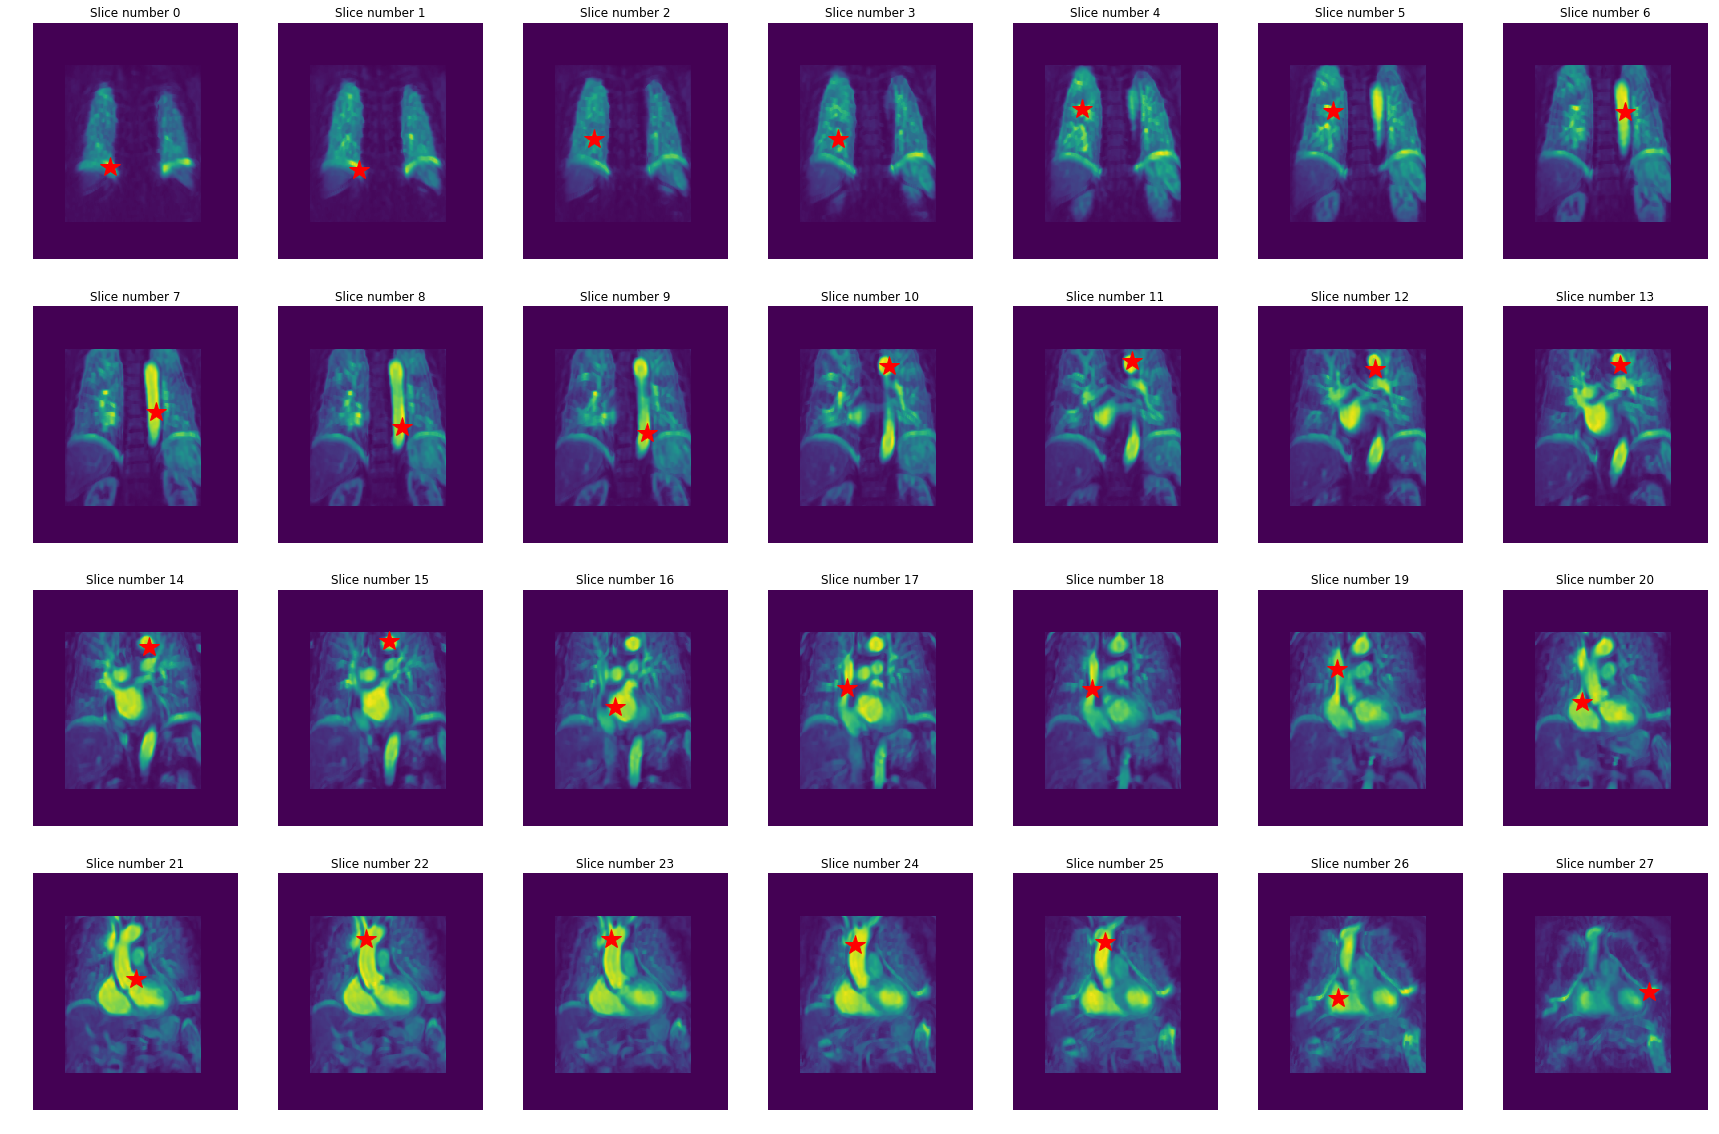

In [13]:
MatrixStd[:,0:40,:] = 0
MatrixStd[:,210:256,:] = 0
MatrixStd[0:40,:,:] = 0
MatrixStd[210:256,:,:] = 0
#Display results
nrows=4
ncols=NumberSlice/4
plt.figure( figsize=(30,20))
for i in range(NumberSlice) :
    Slice = MatrixStd[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    MaxPos = maximum_position(MatrixStd[:,:,i ])
    plt.plot(MaxPos[0], MatrixStd.shape[0] - MaxPos[1], 'r*',  markersize=20)
    plt.axis('off')
    plt.title('Slice number {0:.0f}'.format(i))

Select the slice to work with - generally last one. Is the red dot indicating the diaphragm?


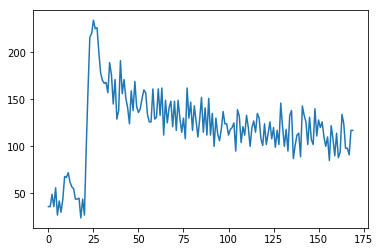

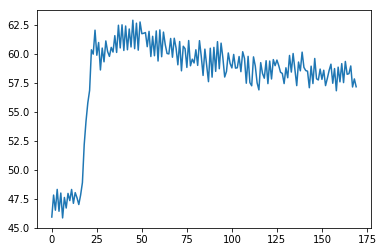

In [104]:
SliceNum = 25
PosV = maximum_position(MatrixStd[:,:,SliceNum ])
plt.plot(Dyn_data[PosV[0], PosV[1], SliceNum,:].squeeze())
plt.figure()
MM = np.zeros((Dyn_data.shape[2],Dyn_data.shape[3]))
for i in range(Dyn_data.shape[3]):
    for ss in range(Dyn_data.shape[2]):
        MM[ss,i] = np.nanmean(Dyn_data[:,:,ss,i])


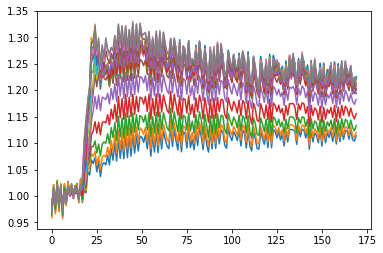

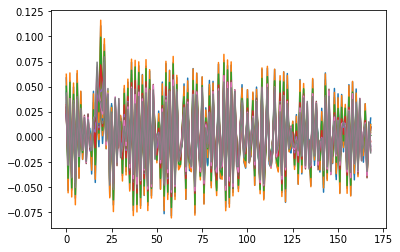

In [124]:
MMn = np.zeros((Dyn_data.shape[2],Dyn_data.shape[3]))
for ii in range(2,20,1):
    MMn[ii,:] = MM[ii,:]/np.mean(MM[ii,1:10])
    plt.plot(MM[ii,:]/np.mean(MM[ii,1:10]))
Diff = np.diff(MMn[:,:],1)
plt.figure()
for ii in range(2,20,1):
    plt.plot(Diff[ii,:])

In [86]:
SliceNum =3
#The position of the diaphgram is chosen as the highest value in the selected slice
PosDiaph = maximum_position(MatrixStd[:,:,SliceNum ]) #max of the variation!
Positions=np.zeros((NAverages*NumFA ))
#We need to select a (vertical) interval around which to search for the actual diaphragm position in each slice and each repetition
VerticalIntervalAroundD = 30
#A second interval is identified for a second round of selection in 'difficult' images (ie, TI=300 ms)
#To increase SNR we can avarage in the orizontal direction - diaphragm should be quite flat at apex
HorizontalIntervalAroundD = 4


Navigator = T1_data_reorder[PosDiaph[0]-HorizontalIntervalAroundD :PosDiaph[0] +HorizontalIntervalAroundD ,PosDiaph[1]-VerticalIntervalAroundD :PosDiaph[1]+VerticalIntervalAroundD,SliceNum,:]
#average in the orizontal direction
Nav = np.array(np.mean(Navigator,0))
#First derivative along vertical dimension
Diff = np.diff(Nav,axis = 0)
#Lung Liver interface is the minimum of the first derivative
Positions[:] = np.argmin(Diff,0) #Lung Liver interface

#choose most common position, without considering less interesting TI  =300ms
MostCommon,a= stats.mode(Positions[:],0)
Distances =np.abs(Positions-MostCommon[0])

#find which acquisition has the diaphragm in the right position or close there
Target =np.zeros((NumFA))


for FA in range(NumFA):
        Target[FA] = np.argmin(Distances[FA*NAverages:FA*NAverages+NAverages]) +1
                                        


[ 2.  4.  3.  2.]


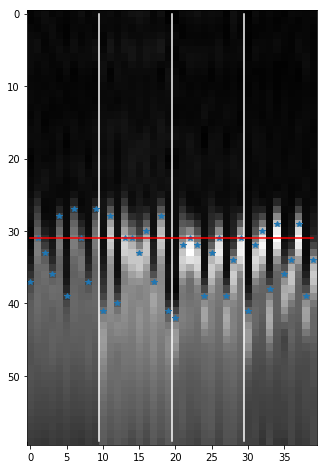

In [87]:
Navigator = T1_data_reorder[PosDiaph[0]-HorizontalIntervalAroundD :PosDiaph[0] +HorizontalIntervalAroundD ,PosDiaph[1]-VerticalIntervalAroundD :PosDiaph[1]+VerticalIntervalAroundD,SliceNum,:]
#average in the orizontal direction
Nav = np.array(np.mean(Navigator,0))
plt.figure( figsize=(8,8))
fig= plt.imshow(np.flip(Nav,0), cmap='gray')
ax = plt.gca();
#make a grid
for nTI in range(NumFA):
    plt.plot(np.ones((VerticalIntervalAroundD*2,1))*NAverages*nTI-0.5, np.arange(0,VerticalIntervalAroundD*2,1), 'w')
plt.plot((VerticalIntervalAroundD*2-1)- Positions[:],'*')

Line = np.ones((NumFA*NAverages,1))*np.int( MostCommon[0])
plt.plot((VerticalIntervalAroundD*2-1)- Line,'r-')

print(Target)


    

In [88]:
TargList = [list(map(int,xt)) for xt in Target]
PIPELINECONTROLLERCONFIG ={}
PIPELINECONTROLLERCONFIG['PERSLICE']= {"ref_slices": '{}'.format(snxxx)}
print('PERSLICE')
for sl, iList in zip(DictSl, TargList): 
    PIPELINECONTROLLERCONFIG['PERSLICE'].update({'image_index_{}'.format(sl): ' '.join(list(map(str,iList)))})
print(PIPELINECONTROLLERCONFIG)
#     print('\tImg Ind {}:\t{}'.format(sl, iList))
print('\tRef Slice:\t{}'.format(snxxx))
write2StudyIndex(os.path.join(Path2Analysis, 'study-index_try.json'), 
                 'pipelineControllerConfig',
                 PIPELINECONTROLLERCONFIG) 


PERSLICE
{'PERSLICE': {'ref_slices': 'sn000011', 'image_index_sl001': '3 2 3 2 4 4', 'image_index_sl002': '1 4 4 1 1 1', 'image_index_sl003': '1 2 3 2 1 4', 'image_index_sl004': '3 2 1 2 1 2', 'image_index_sl005': '1 2 4 2 1 4', 'image_index_sl006': '1 1 5 4 4 3'}}
	Ref Slice:	sn000011
***** File /Volumes/Data-1/L-ROY-16-23/patient-data/001/analysis/study-index_try.json updated *****


Check the chosen images 

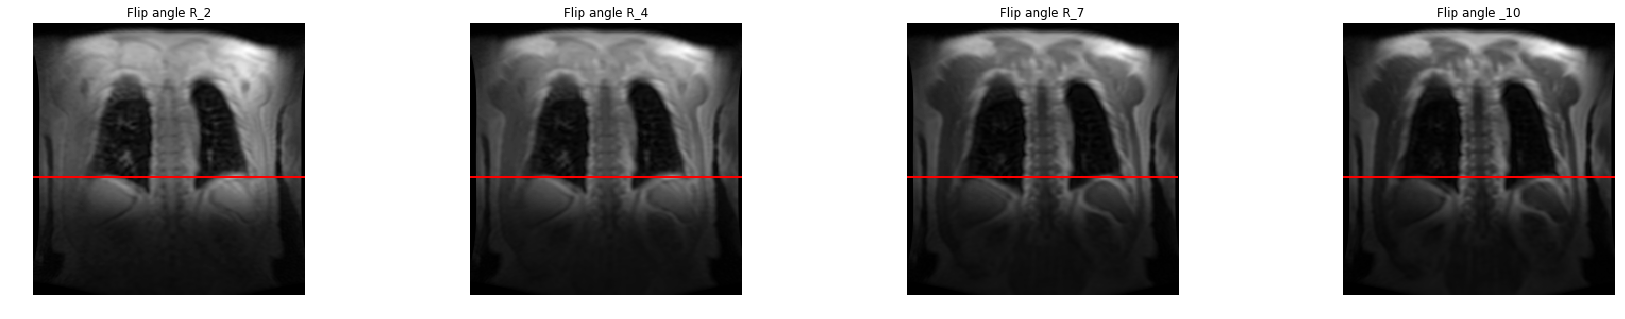

In [88]:
plt.figure( figsize=(30,5))
for i in range(NumFA):
        ind = int(Target[i]-1)
        Slice =  T1_data[:,:,SliceNum,i,ind ]
        Slice = Slice.squeeze()
        ax = plt.subplot(1,NumFA,i+1)
        im=plt.imshow(np.rot90(Slice,1), cmap='gray')
        Line = np.ones((Data.shape[0],1))*np.int( Data.shape[0] - PosDiaph[1] +(VerticalIntervalAroundD-MostCommon[0]) )
        plt.plot( Line,'r-', linewidth=2)
        plt.axis('off')
        for key, value in DictFA.items():
            if value == i:
                plt.title('Flip angle {0:s}'.format(key ))
